# Ice-thickness length scale smoothing

We are implmenting eq 2 and 3 from https://polarresearch.net/index.php/polar/article/view/3498/9172

In [1]:
from scipy.ndimage import gaussian_filter, generic_filter
import xarray as xr

In [2]:
from pathlib import Path
from typing import Dict, List, Optional, Union

import cartopy.crs as ccrs
import cf_xarray.units  # pylint: disable=unused-import
import geopandas as gp
import matplotlib
import numpy as np
import pint_xarray  # pylint: disable=unused-import
import pylab as plt
import seaborn as sns
import xarray as xr
from matplotlib import cm, colors
from matplotlib.colors import LightSource
from shapely import get_coordinates

from glacier_flow_tools.utils import (
    blend_multiply,
    figure_extent,
    get_dataarray_extent,
    register_colormaps,
)

register_colormaps()


## This plotting function makes a nice hillshade so it's easier to validate the results

In [3]:
def plot_glacier(
    surface: xr.DataArray,
    overlay: xr.DataArray,
    cmap: str = "viridis",
    vmin: float = 10,
    vmax: float = 1500,
    ticks: Union[List[float], np.ndarray] = [10, 100, 250, 500, 750, 1500],
    fontsize: float = 6,
    figwidth: float = 3.2,
):
    """
    Plot a surface over a hillshade, add profile and correlation coefficient.

    This function plots a surface over a hillshade, adds a profile and correlation coefficient.
    The plot is saved as a PDF file in the specified result directory.

    Parameters
    ----------
    surface : xr.DataArray
        The surface to be plotted over the hillshade.
    overlay : xr.DataArray
        The overlay to be added to the plot.
    result_dir : Union[str, Path]
        The directory where the result PDF file will be saved.
    cmap : str, optional
        The colormap to be used for the plot, by default "viridis".
    vmin : float, optional
        The minimum value for the colormap, by default 10.
    vmax : float, optional
        The maximum value for the colormap, by default 1500.
    ticks : Union[List[float], np.ndarray], optional
        The ticks to be used for the colorbar, by default [10, 100, 250, 500, 750, 1500].
    fontsize : float, optional
        The font size to be used for the plot, by default 6.
    figwidth : float, optional
        The width of the figure in inches, by default 3.2.

    Examples
    --------
    >>> plot_glacier(profile_series, surface, overlay, '/path/to/result_dir')
    """
    plt.rcParams["font.size"] = fontsize
    cartopy_crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
    # Shade from the northwest, with the sun 45 degrees from horizontal
    light_source = LightSource(azdeg=315, altdeg=45)
    glacier_overlay = overlay
    glacier_surface = surface.interp_like(glacier_overlay)

    extent = get_dataarray_extent(glacier_overlay)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    v = mapper.to_rgba(glacier_overlay.to_numpy())
    z = glacier_surface.to_numpy()

    ar = 1.0  # initial aspect ratio for first trial
    wi = figwidth  # width in inches
    hi = wi * ar  # height in inches

    fig = plt.figure(figsize=(wi, hi))
    ax = fig.add_subplot(111, projection=cartopy_crs)
    rgb = light_source.shade_rgb(v, elevation=z, vert_exag=0.01, blend_mode=blend_multiply)
    # Use a proxy artist for the colorbar...
    im = ax.imshow(v, cmap=cmap, vmin=vmin, vmax=vmax)
    im.remove()
    ax.imshow(rgb, extent=extent, origin="upper", transform=cartopy_crs)
    ax.gridlines(
        draw_labels={"top": "x", "left": "y"},
        dms=True,
        xlocs=np.arange(-50, 0, 1),
        ylocs=np.arange(50, 88, 1),
        x_inline=False,
        y_inline=False,
        rotate_labels=20,
        ls="dotted",
        color="k",
    )

    fig.colorbar(im, ax=ax, shrink=0.5, pad=0.025, label=overlay.units, extend="both", ticks=ticks)
    plt.draw()

    # Get proper ratio here
    xmin, xmax = ax.get_xbound()
    ymin, ymax = ax.get_ybound()
    y2x_ratio = (ymax - ymin) / (xmax - xmin)
    fig.set_figheight(wi * y2x_ratio)
    fig.tight_layout()
    plt.close()
    return fig


## We use Bedmachine as it has both surface and ice thickness

In [4]:
#ds = xr.open_dataset("/mnt/storstrommen/data/MCdataset/BedMachineGreenland-v5.nc")
ds = xr.open_dataset("/Users/andy/Google Drive/My Drive/data/MCdataset/BedMachineGreenland-v5.nc")

## Select Jakobshavn

In [5]:
jak_ds = ds.sel(x=slice(-226_000, -140_000), y=slice(-2_250_000, -2_300_000))

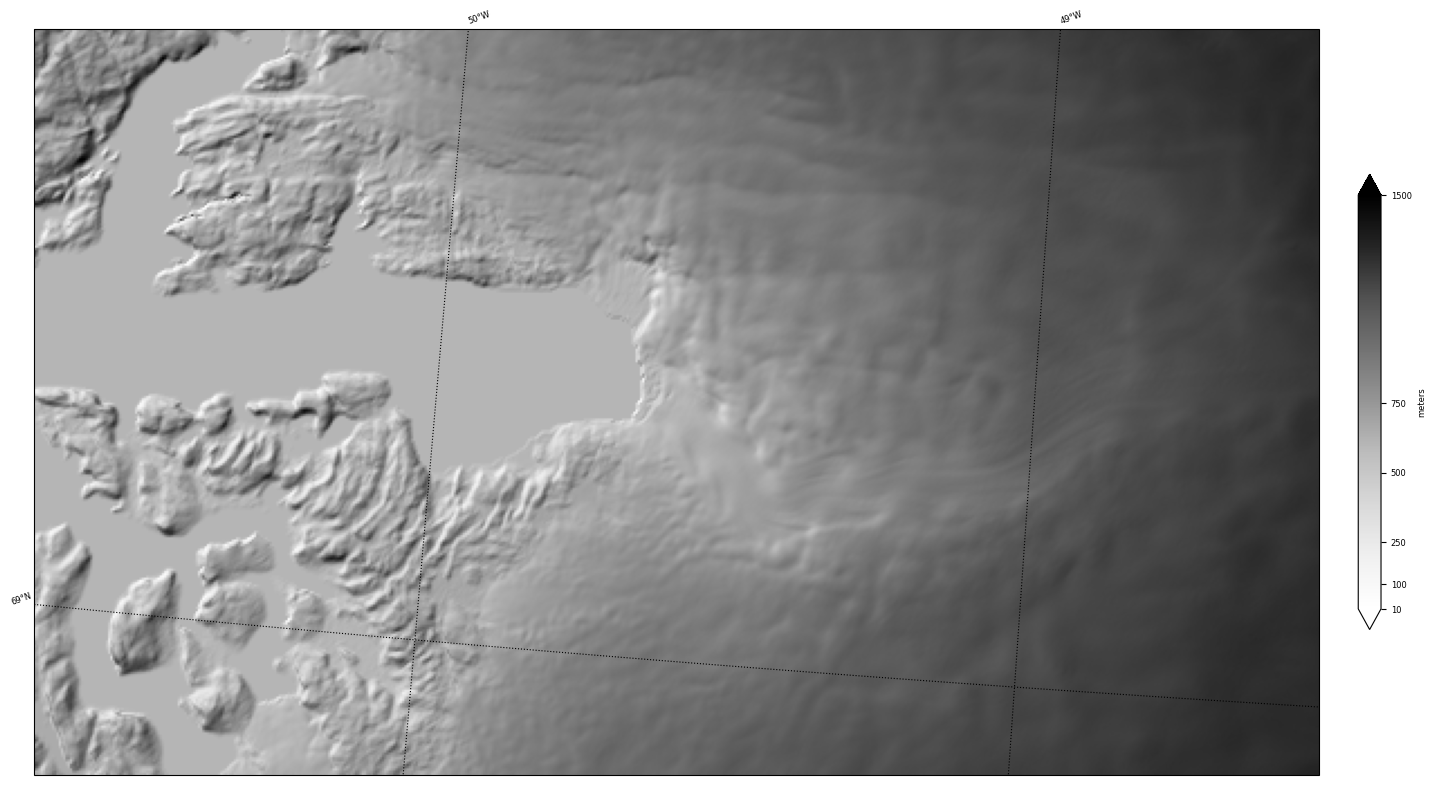

In [6]:
dem = jak_ds["surface"]
plot_glacier(dem, dem, cmap="Grays", figwidth=16)

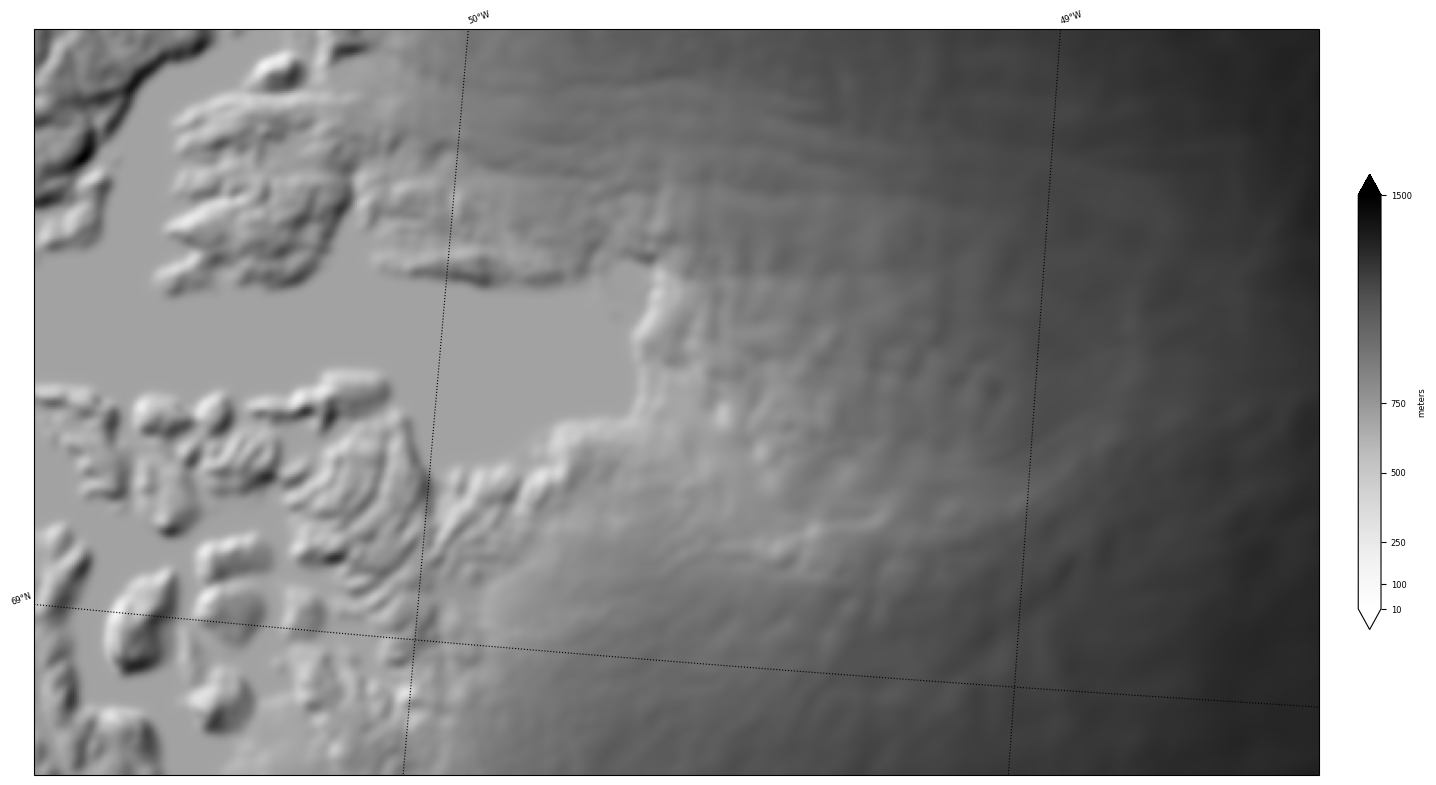

In [7]:
dem_smoothed_gaussian = jak_ds["surface"].copy()
dem_smoothed_gaussian.values = gaussian_filter(jak_ds["surface"], 2)
plot_glacier(dem_smoothed_gaussian, dem_smoothed_gaussian, cmap="Grays", figwidth=16)

In [8]:
def kernel_gaussian(sigma, window: int = 3):
    r = np.arange(-(window-1) / 2, (window-1) / 2)
    X, Y = np.meshgrid(r, r)
    r_squared = X**2 + Y**2
    return 1.0 / (2.0 * np.pi * sigma*sigma) * np.exp(-r_squared / (2 * sigma*sigma))

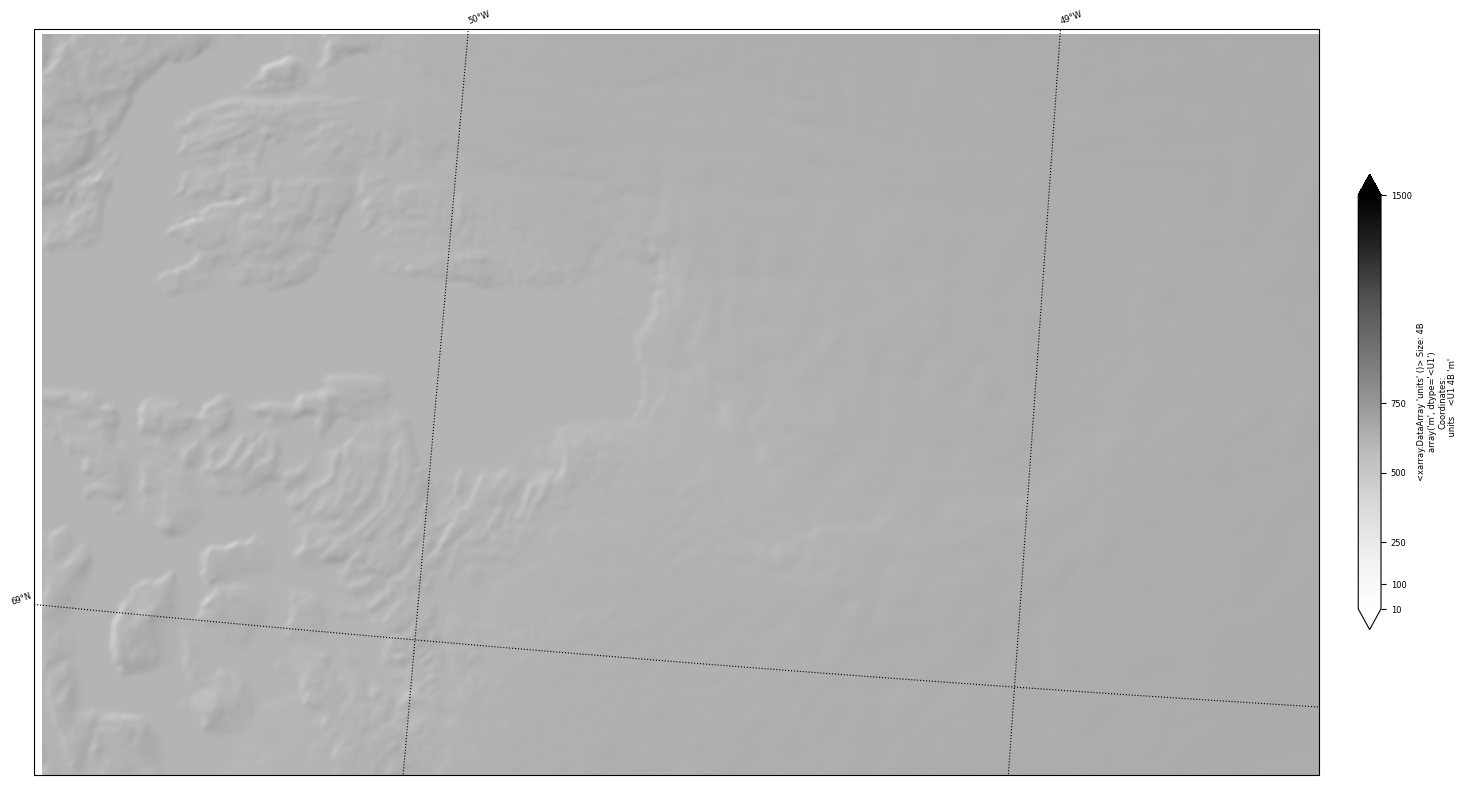

In [10]:
window = 3
weights_gaussian = xr.DataArray(kernel_gaussian(2, window=window), dims=["window_x", "window_y"])
dem_smoothed_rolling = jak_ds["surface"].rolling({"x": window-1, "y": window-1}, center=True).construct(x='window_x', y='window_y').dot(weights_gaussian)
dem_smoothed_rolling["units"] = "m"
plot_glacier(dem_smoothed_rolling, dem_smoothed_rolling, cmap="Grays", figwidth=16)

## Gaussian smoothing

$$ \omega=\frac{1}{2 \pi \sigma^2} e^{-\frac{x^2+y^2}{2 \sigma^2}}$$

How do we implment this as a **generic_filter**? The implementation of **gaussian_filter** is here: https://github.com/scipy/scipy/blob/v1.13.1/scipy/ndimage/_filters.py#L286-L390.
It uses *np.correlate* instead of convolve, and loops over all axis. Can we do that too?

Maybe we can use https://github.com/scipy/scipy/blob/v1.13.1/scipy/ndimage/_filters.py#L186 for inspiration. We need to compute $\sigma$ scaled by ice thickness in a sensible way. 

## Triangular smoothing

$$ \omega = \max\left( \frac{\sqrt{x^2+y^2}}{\sigma},0 \right)$$